# Logistic Regression Model

In [70]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
import seaborn as snus
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


In [92]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_0'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasification of the vehicle'] == 0)).astype(int)
c:\Users\mikol\PycharmProjects\Pre-selection Assignment\Pre-selection-Assignment\source\utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_purpose_1_1'] = ((df_loan_purpose['loan_purpose_1.0'] == 1) & (df['Clasification of

## Old Model 

In [ ]:
cm_r = confusion_matrix(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(train_data['Default indicator'], (train_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r


(array([[17294, 17003],
        [  533,   562]], dtype=int64),
 0.5045207956600362)

In [ ]:
cm_r = confusion_matrix(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
accuracy_r = accuracy_score(val_data['Default indicator'], (val_data['_r_'] > 0.5).astype(int))
cm_r, accuracy_r


(array([[1724, 1703],
        [  61,   58]], dtype=int64),
 0.5025380710659898)

## Benchmark Model

In [93]:
X_train = train_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_train = train_data['Default indicator']

X_val = val_data.drop(columns=['Default indicator', '_r_', 'Application date'])
y_val = val_data['Default indicator']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [96]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
logit_result = logit_model.fit(maxiter=1000)

# Przewidywanie na danych walidacyjnych
y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)

# Dokładność modelu
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Macierz pomyłek
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Optimization terminated successfully.
         Current function value: 0.114605
         Iterations 9
Accuracy: 0.9670050761421319
Confusion Matrix:
[[3427    0]
 [ 117    2]]


Text(0, 0.5, 'True Positive Rate')

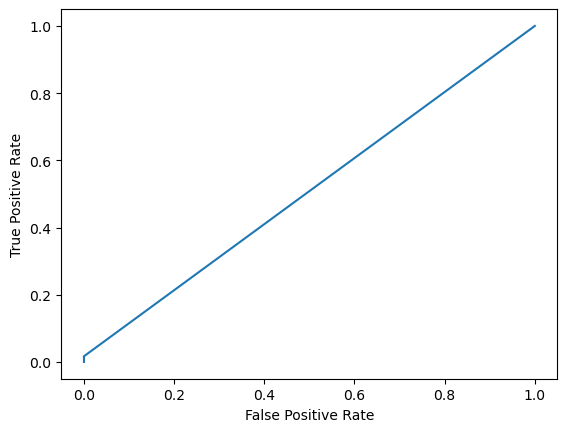

In [5]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 

## cor

In [97]:
# Oblicz macierz korelacji
correlation_matrix = X_train.corr()

# Zdefiniuj próg korelacji
threshold = 0.50  # Możesz dostosować ten próg według potrzeb

# Utwórz macierz boolowską dla wysokiej korelacji (zarówno dodatniej, jak i ujemnej)
high_correlation_mask = (abs(correlation_matrix) >= threshold) & (correlation_matrix != 1.0)

# Znajdź indeksy kolumn, które mają wysoką korelację (zarówno dodatnią, jak i ujemną) z innymi kolumnami
highly_correlated_columns = set()
for col in correlation_matrix.columns:
    highly_correlated_columns.update(correlation_matrix.index[high_correlation_mask[col]])

# Odrzuć kolumny o wysokiej korelacji (zarówno dodatniej, jak i ujemnej) z innymi kolumnami
selected_features = [col for col in X_train.columns if col not in highly_correlated_columns]



In [98]:
len(selected_features)

26

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_val_scaled = scaler.transform(X_val[selected_features])


In [100]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train_scaled))
logit_result = logit_model.fit(maxiter=1000)

# Przewidywanie na danych walidacyjnych
y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)

# Dokładność modelu
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Macierz pomyłek
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Optimization terminated successfully.
         Current function value: 0.126122
         Iterations 9
Accuracy: 0.9664410603496898
Confusion Matrix:
[[3426    1]
 [ 118    1]]


In [26]:
for f in selected_features:
    print(f)

Credit duration
Installment amount
Spendings estimation
Limit on credit card
Amount on current account
Amount on savings account
Arrear in last 3 months
Arrear in last 12 months
Credit bureau score
work experience
loan_purpose_1_0
loan_purpose_2_0
loan_purpose_2_1
Distribution channel_2
Distribution channel_3
Payment frequency_3
Payment frequency_6
profession of main applicant_2
profession of main applicant_3
profession of main applicant_4
profession of main applicant_5
profession of main applicant_6
profession of main applicant_7
profession of second applicant_1.0
profession of second applicant_2.0
profession of second applicant_3.0
profession of second applicant_4.0
profession of second applicant_6.0
profession of second applicant_7.0
marital status of main applicant_1
marital status of main applicant_2
marital status of main applicant_3
marital status of main applicant_4


## Smote

In [103]:
smot = SMOTE(sampling_strategy=0.3, random_state=42)

# Oversampling klasy mniejszościowej
oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)

# Tworzenie ramki danych z równowagą klas
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

# Sprawdzenie liczby wystąpień klas
readyDF['Default indicator'].value_counts()


Default indicator
0.0    34297
1.0    10289
Name: count, dtype: int64

In [107]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

# Przewidywanie na danych walidacyjnych
y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)

# Dokładność modelu
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Macierz pomyłek
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)



Optimization terminated successfully.
         Current function value: 0.473744
         Iterations 6
Accuracy: 0.9498025944726453
Confusion Matrix:
[[3352   75]
 [ 103   16]]


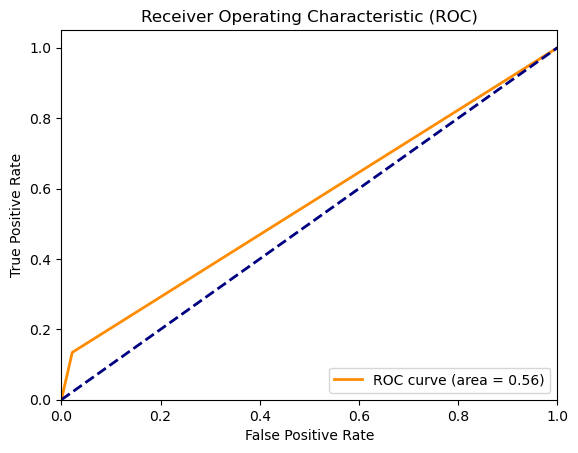

In [108]:
# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [109]:
smot = SMOTE(sampling_strategy=1, random_state=42)

# Oversampling klasy mniejszościowej
oversampled_X, oversampled_Y = smot.fit_resample(X_train_scaled, y_train)

# Tworzenie ramki danych z równowagą klas
readyDF = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

# Sprawdzenie liczby wystąpień klas
readyDF['Default indicator'].value_counts()

Default indicator
0.0    34297
1.0    34297
Name: count, dtype: int64

In [110]:
logit_model = sm.Logit(oversampled_Y, sm.add_constant(oversampled_X))
logit_result = logit_model.fit(maxiter=1000)

# Przewidywanie na danych walidacyjnych
y_pred = (logit_result.predict(sm.add_constant(X_val_scaled)) > 0.5).astype(int)

# Dokładność modelu
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Macierz pomyłek
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Optimization terminated successfully.
         Current function value: 0.605365
         Iterations 7
Accuracy: 0.6765369430344049
Confusion Matrix:
[[2325 1102]
 [  45   74]]


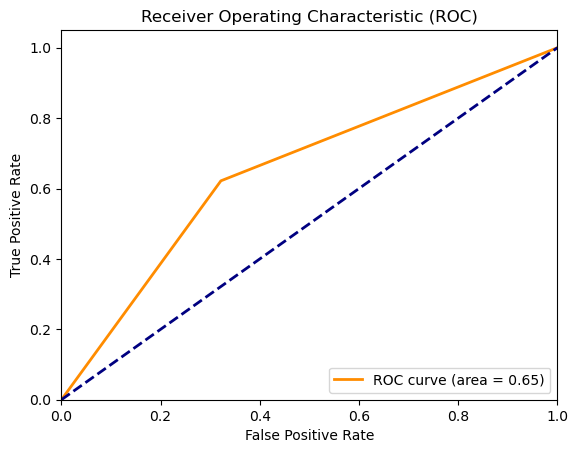

In [111]:
# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()